# Integrating scRNA-seq Datasets with CONOS (Clustering on Networks of Samples)

**Notebook Authors**: Anthony S. Castanza, PhD & Edwin F. Juárez, PhD
<br>
**Contact Information**: acastanza@ucsd.edu & ejuarez@ucsd.edu

## Summary


This notebook implements the data processing pipeline from the Clustering On Networks Of Samples (CONOS) package **version 1.1.1** to integrate multiple independent single cell RNA-seq experiments into a common projection. The This common projection can then be used for investigating gene expression relationships and cell identities across studies in an integrated space.

The underlying code for this notebook based on the CONOS package and is available from: https://github.com/hms-dbmi/conos/
<br>The underlying code for Pagoda2 is available from: https://github.com/hms-dbmi/pagoda2

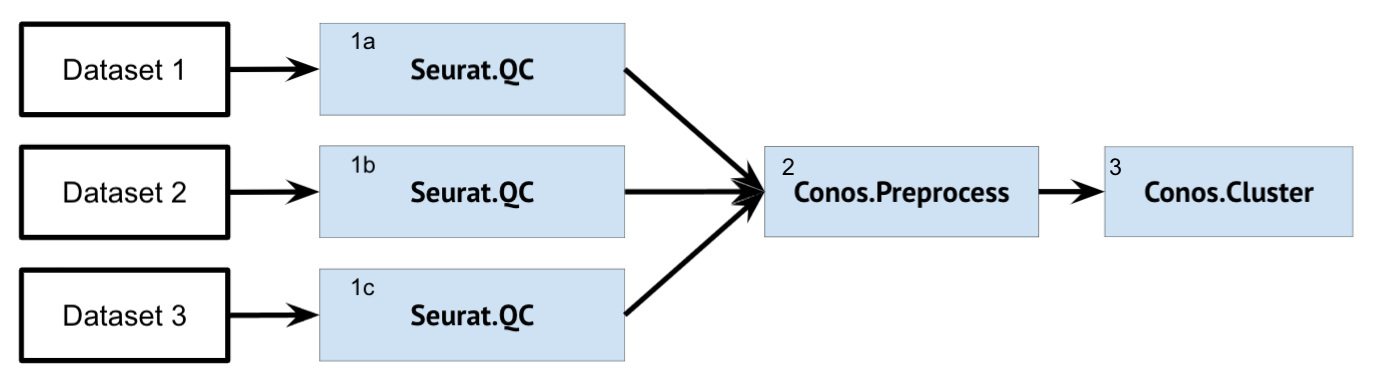

#### Conos Summary

Conos _harmonizes_ different samples, it does not perfom batch correction.

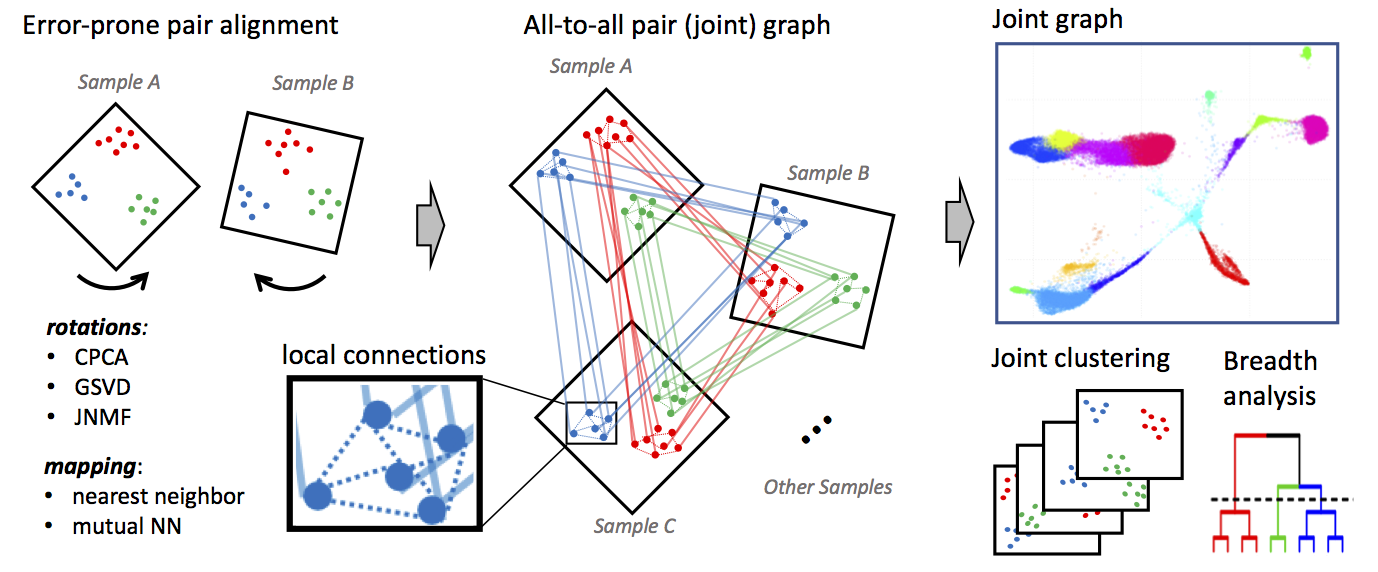
source: https://github.com/kharchenkolab/conos#clustering-on-network-of-samples

## Login to GenePattern

In [7]:
# Requires GenePattern Notebook: pip install genepattern-notebook
import gp
import genepattern

# Username and password removed for security reasons.
genepattern.display(genepattern.session.register("https://cloud.genepattern.org/gp", "", ""))

GPAuthWidget()

## Preprocess Datasets (with Pagoda2)

Performs independent clustering of each of the single-cell quantification tables using the Pagoda2 method. These clustered results are then projected into C/PCA space and embedded into a joint graph.

<div class="well well-sm">
The next version of the Conos Module will include the option of reading in a Seurat Object
</div>

<div class="well well-sm">
<b>Note:</b> Conos takes in text files (TXT), with tab-separated gene expression matrices (rows are genes, columns are unique cells).
</div>

In [8]:
conos_preprocess_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00409')
conos_preprocess_job_spec = conos_preprocess_task.make_job_spec()
conos_preprocess_job_spec.set_parameter("file_list", ["https://datasets.genepattern.org/data/module_support_files/Conos/data/conos_data/pbmc.txt", "https://datasets.genepattern.org/data/module_support_files/Conos/HNSCC_noribo.txt", "https://datasets.genepattern.org/data/module_support_files/Conos/MEL_noribo.txt"])
conos_preprocess_job_spec.set_parameter("knn", "40")
conos_preprocess_job_spec.set_parameter("perplexity", "50")
conos_preprocess_job_spec.set_parameter("pagoda_odgenes", "3000")
conos_preprocess_job_spec.set_parameter("projection_method", "PCA")
conos_preprocess_job_spec.set_parameter("ncomps", "50")
conos_preprocess_job_spec.set_parameter("conos_odgenes", "1000")
conos_preprocess_job_spec.set_parameter("job.memory", "4Gb")
conos_preprocess_job_spec.set_parameter("job.queue", "gp-cloud-default")
conos_preprocess_job_spec.set_parameter("job.cpuCount", "1")
conos_preprocess_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(conos_preprocess_task)

job360418 = gp.GPJob(genepattern.session.get(0), 360418)
genepattern.display(job360418)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00409')

GPJobWidget(job_number=360418)

## Generate and Capture Joint Graph Clusters

Select the <tt>conos_preprocess_output.rds</tt> file produced as the output of the Conos.Preprocess module as the input conos object.

Clustering is performed on the joint graph produced as the output of Conos.Preprocess using both Leiden community clustering and Walktrap clustering. The clustered joint graph is then projected into UMAP space for visualiztion.

In [9]:
conos_cluster_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00410')
conos_cluster_job_spec = conos_cluster_task.make_job_spec()
conos_cluster_job_spec.set_parameter("conos_object", "https://cloud.genepattern.org/gp/jobResults/360418/conos_preprocess_output.rds")
conos_cluster_job_spec.set_parameter("runleiden", "True")
conos_cluster_job_spec.set_parameter("leiden_resolution", "1.0")
conos_cluster_job_spec.set_parameter("runwalktrap", "True")
conos_cluster_job_spec.set_parameter("walktrap_steps", "10")
conos_cluster_job_spec.set_parameter("umap_distance", "0.05")
conos_cluster_job_spec.set_parameter("umap_spread", "5")
conos_cluster_job_spec.set_parameter("job.memory", "4Gb")
conos_cluster_job_spec.set_parameter("job.walltime", "02:00:00")
conos_cluster_job_spec.set_parameter("job.cpuCount", "3")
genepattern.display(conos_cluster_task)

job361487 = gp.GPJob(genepattern.session.get(0), 361487)
genepattern.display(job361487)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00410')

GPJobWidget(job_number=361487)

<div class="well well-sm">
    
- Look at Per-sample_Global_Leiden1_Clusters.png to observe the three cohorts separately but with harmonized clusters.
- Look at UMAP_space_Leiden_Clusters.png for the same clusters but projected into the same space.
- Look at Leiden1_Cluster_Composition.png to evaluate how well those cohorts mixed.
</div>

### Expand in case of emergency

In [ ]:
job197957 = gp.GPJob(genepattern.session.get(0), 197957)
genepattern.display(job197957)

## Import CONOS Output Data for Further Exploration

In [4]:
%load_ext rpy2.ipython
%load_ext nbtools.r_support

import warnings
warnings.simplefilter(action='ignore')

import os
import requests

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

import genepattern
@genepattern.build_ui(name="Import Conos.Cluster output for further analysis", parameters={
    "conosgraph": {
        "name": "Conos Cluster Output:",
        "description": "conos_cluster_output.rds from Conos.Cluster module",
        "type": "file",
        "kinds": ["rds"]
    },
    "output_var": {
    "name": "results",
    "description": "",
    "default": "quantification_source",
    "hide": True
    }
})

def get_files_function(conosgraph):
    job_widget = nbtools.UIOutput(status="Getting file from the GenePattern server...")
    display(job_widget)
    f = gp.GPFile(genepattern.session.get(0), conosgraph)
    resp = requests.get(conosgraph, headers={
        'Authorization': f.server_data.authorization_header(), 
        'User-Agent': 'GenePatternRest'})
    job_widget.status = f'Writing conos_cluster_output.rds (size: {sizeof_fmt(int(resp.headers["Content-length"]))}) file to your workspace.'
    with open('conos_cluster_output.rds', "wb") as conos_file:
        conos_file.write(resp.content)
    job_widget.status = 'conos_cluster_output.rds successfully retrieved.'

newrds = "unread"
%Rpush newrds

UIBuilder(function_import='nbtools.tool(id="Import Conos.Cluster output for further analysis", origin="Noteboo…

## Plot Genes of Interest on Embedded Joint Graph

Import the <tt>conos_cluster_output.rds</tt> from the Conos.Cluster module to enable exploration of gene expression on the joint graph. The first cell enables the R UI and passes GenePattern login credentials into the Notebook R session so that the Conos.cluster output can be retreived from the server directly.

Expression of genes of interest can be projected onto the joint graph for visualization of cluster markers.

In [14]:
%%r_build_ui -w 800 {"name": "Plot gene expression on the joint graph", "parameters": {"geneofinterest": { "name": "Gene Identifier:", "description": "A gene identifier to plot expression on the embedded map (e.g. MS4A1, CD74)", "type": "text"}, "paintcluster": { "name": "Show Clustering:", "description": "Option to show clustering information beside gene expression", "type": "choice", "choices": {"None": "none", "Show Leiden": "leiden", "Show Walktrap": "walktrap", "Show Both Leiden and Walktrap": "both"}, "default": "none"},  "output_var": { "hide": "True" } }}

customplot <- function(geneofinterest,paintcluster){
    cat("Creating graphs...")
    
    if(!require(conos)){
        print("Conos is not installed. Installing it now")
#         install.packages("conos")
        library(conos)
    }
    
    if (paintcluster == "none"){
    print(con$plotPanel(color.by='gene', gene=paste0(geneofinterest)))}

    if (runleiden == TRUE & paintcluster == "leiden"){
    print(cowplot::plot_grid(con$plotPanel(alpha=0.1, clustering='leiden'),
    con$plotPanel(color.by='gene', gene=paste0(geneofinterest))))}

    if (runwalktrap == TRUE & paintcluster == "walktrap"){
#     pdf(paste0("Walktrap_Clusters_with_",geneofinterest,"_Expression.pdf"), width=14.88, height=8.2)
#     print(cowplot::plot_grid(con$plotPanel(alpha=0.1, clustering='walktrap'),
#     con$plotPanel(alpha=0.1, color.by='gene', title=paste0(geneofinterest,"_Expression"), gene=paste0(geneofinterest))))
#     dev.off()
    print(cowplot::plot_grid(con$plotPanel(alpha=0.1, clustering='walktrap'),
    con$plotPanel(color.by='gene', gene=paste0(geneofinterest))))}

    if (runleiden == TRUE & runwalktrap == TRUE & paintcluster == "both"){
#     pdf(paste0("Leiden_and_Walktrap_Clusters_with_",geneofinterest,"_Expression.pdf"), width=14.88, height=8.2)
#     print(cowplot::plot_grid(con$plotPanel(alpha=0.1, clustering='leiden'), con$plotPanel(alpha=0.1, clustering='walktrap'),
#     con$plotPanel(alpha=0.1, color.by='gene', title=paste0(geneofinterest,"_Expression"), gene=paste0(geneofinterest))))
#     dev.off()
    print(cowplot::plot_grid(con$plotPanel(alpha=0.1, clustering='leiden'), con$plotPanel(alpha=0.1, clustering='walktrap'),
    con$plotPanel(color.by='gene', gene=paste0(geneofinterest))))}
    cat("... done!")
    return()
}

# print(R.Version())

if (newrds == "unread") {
cat('Reading conos_cluster_output.rds (this may take about a minute)...')
conos <- readRDS("conos_cluster_output.rds")
cat('...done!')
con <- conos$con
runleiden <- conos$runleiden
runwalktrap <- conos$runwalktrap
newrds <- "read"
}

customplot(geneofinterest,paintcluster)

UIBuilder(function_import='nbtools._r_wrappers["7B9822EAF92EB443DAF5511E2A44E663"]', name='Plot gene expressio…

### CD74 expression sample-independent clusters

Most B-cells and T-cells express CD74.

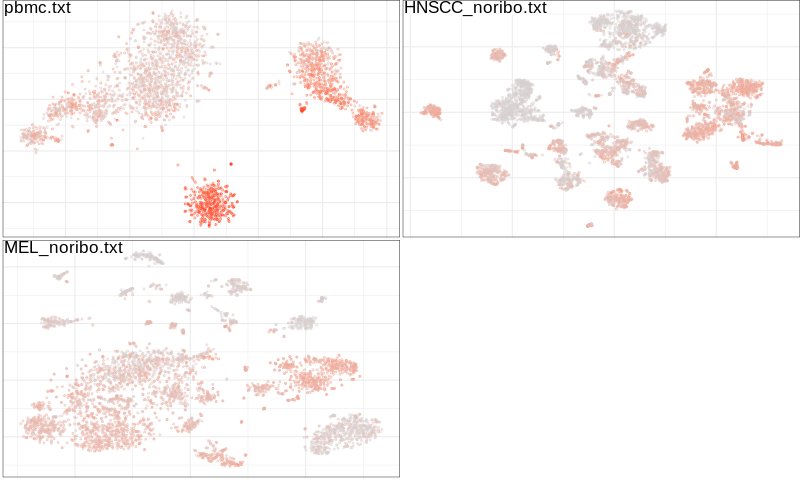

### CD74 expression, Leiden clustering and sample-independent clusters

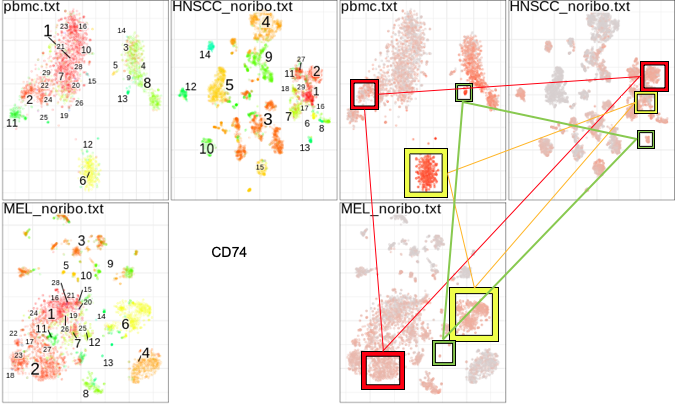

### GZMK expression Leiden clustering and sample-independent clusters

Granzyme K is a marker for a type of T-Cell

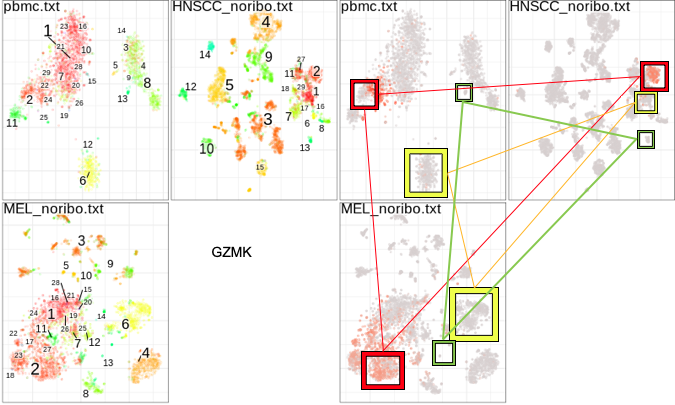

### "A scientist looking at Conos graphs"

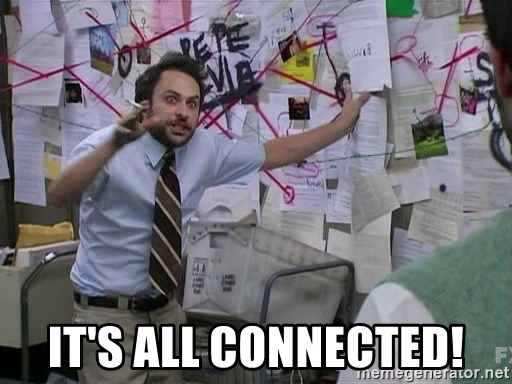

## Cleanup files

In [6]:
import os
@genepattern.build_ui(name="Cleanup temporary files", parameters={
    "output_var": {
    "name": "results",
    "description": "",
    "default": "quantification_source",
    "hide": True
    }
})

def delete_rds():
    job_widget = nbtools.UIOutput(status="Deleteing seurat_preprocessed_dataset.clustered.rds.rds file from your workspace.")
    display(job_widget)
    os.remove('seurat_preprocessed_dataset.clustered.rds.rds')
    job_widget.status = 'seurat_preprocessed_dataset.clustered.rds.rds deleted!'
    print('done!')

UIBuilder(function_import='nbtools.tool(id="Cleanup temporary files", origin="Notebook").function_or_method', …

## References
 
- Barkas N., Petukhov V., Nikolaeva D., Lozinsky Y., Demharter S., Khodosevich K., Kharchenko P.V. 2018. Wiring together large single-cell RNA-seq sample collections. bioRxiv 460246; doi: https://doi.org/10.1101/460246 (<a href='https://www.biorxiv.org/content/10.1101/460246v1'>Link</a>).


- Fan J., Salathia N., Liu R., Kaeser G.E., Yung Y.C., Herman J.L., Kaper F., Fan J.B., Zhang K., Chun J., Kharchenko P.V. 2016. Characterizing transcriptional heterogeneity through pathway and gene set overdispersion analysis. Nat Methods. 2016;13(3):241-4. (<a href='https://www.nature.com/articles/nmeth.3734'>Link</a>).
